In [1]:
# Classification machine learning algorithmes
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.utils import shuffle

#Loading data

# X: The data frame of features
X = pickle.load(open("features_final3.p" , "rb"))

# y: the list of targets (classes) 
y = pickle.load(open("target_data_final3.p" , "rb"))

# Helper Functions

In [69]:
#plot the importance of features used during the classification process
def plot_feature_importances(model):
    #number of features : 24
    n_features = len(list(X))
    #Horizontal bar chart
    plt.barh(range(n_features), model.feature_importances_,align='center')
    plt.yticks(range(n_features), list(X))
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

# Preprocessing the extracted features

The **<span style="color:red;">RobustScaler</span>** uses a similar method to the **Min-Max scaler** but it instead uses the **interquartile range**,
rathar than the **min-max**, so that it is robust to **outliers**. Therefore it follows the formula:

<span style="color:blue;">RobustScaler</span> = $\frac{x_{i}-Q_{1}(x)}{Q_{3}(x)-Q_{1}(x)}$


In [70]:
from sklearn import preprocessing

#MinMaxScaler

scaler = preprocessing.MinMaxScaler()
robust_scaled_X = scaler.fit_transform(X)
robust_scaled_X = pd.DataFrame(robust_scaled_X, columns=X.columns)

# Randomly divide the dataset into a separate training and test set

In [2]:
from sklearn.model_selection import train_test_split

#This stratify parameter makes a split so that the proportion of values in the sample produced 
#will be the same as the proportion of values provided to parameter stratify

# random_state = 66 in order to get reproductible results

#Technique for shuffling the data in order to break the order of the files
#X2, y2 = shuffle(X, y, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  stratify=y, shuffle=True, random_state=66)

#scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(robust_scaled_X, y, test_size=0.2,  stratify=y, random_state=66)

print(X_train.shape, X_test.shape)

print(len(y_train), len(y_test))

(15421, 18) (3856, 18)
15421 3856


# KNN Classifier

- **KNN** is a typical example of a lazy learner. It doesn't learn a **discriminative function** from the training data, but **memorizes** the training dataset instead.

- The right choice of **k_neighbors** is crucial to find a good balance between overfitting and underfitting. We also have to make sure that we choose a **distance metric** that is appropriate for the features in the dataset:
    - **Minkowski Distance** = $\sqrt[p]{\sum{(x_i - y_i)^p}}$
    - **Euclidean Distance** = $\sum(|x_i - y_i|)$
    - **Manhattan Distance** = $Max(|x_i - y_i|)$

n_neighbors= 3  the accuracy is:0.864 weights: distance


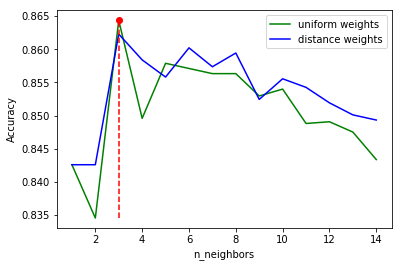

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

#arrays in order to store the accuracy
accuracy = []

#knn max neighbors initialisation
max_neighbors = 15
neighbors_setting = range(1,max_neighbors)

#initialization of the best parameters 
best_k_neibors = 1
best_accuracy = 0

#in order to make evaluation later (log loss)
best_class_Points=[]
best_pred_probabilities=[]

for weights in ['uniform', 'distance']:
        for k in neighbors_setting:    
            # Knn with p = 1: Manhattan Distance, using weighted distance in order to include the importance of the distance (near points have more importance in classification decision then the far ones ) 
            knn = KNeighborsClassifier(n_neighbors=k, weights= weights,  p = 1)
            
            #train the knn
            knn.fit(X_train, y_train)
            
            #making predictions
            classified_Points = knn.predict(X_test)
            
            pred_probabilities = knn.predict_proba(X_test)
            
            #calculating the accuracy of predictions the test data set
            acc = accuracy_score(y_test, classified_Points)
            
            accuracy.append(acc)

            best_k_neibors, best_accuracy, best_class_Points, best_pred_probabilities  = (k, acc, classified_Points, pred_probabilities) if acc > best_accuracy else (best_k_neibors, best_accuracy, best_class_Points, best_pred_probabilities)

print("n_neighbors=",best_k_neibors," the accuracy is:{:.3f}".format(best_accuracy), "weights:", weights)

# accuracy[0:14] : the accuracy of the uniform weights based method        
plt.plot(neighbors_setting, accuracy[0:max_neighbors-1], color="g",label="uniform weights")

# accuracy[0:14] : the accuracy of the distance weights based method
plt.plot(neighbors_setting, accuracy[max_neighbors-1:2*max_neighbors-2], color="b",label="distance weights")

#plot the best accuracy on the graphe
plt.plot([best_k_neibors,best_k_neibors], [min(accuracy),best_accuracy], "r--")
plt.plot(best_k_neibors, best_accuracy, "ro")

plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")

#display the legend of the graphe
plt.legend()

# Cross Validation

- train_test_split performs a random split of the data, if we are “lucky” when randomly splitting the data,
all examples that are hard to classify end up in the training set.
    
- In that case, the test set will only contain “easy” examples,and our test set accuracy will be 
unrealistically high.

- Conversely, if we are “unlucky,” we might have randomly put all the hard-to-classify examples in the test set 
and consequently obtain an unrealistically low score.

- So because of that, cross-validation is the best method to evaluate how well a given machine learning algorithm 
will generalize when trained on a specific dataset.

- I am going to use a stratified k-fold cross-validation with Shuffling. In stratified cross-validation, we split the data such that the proportions between classes are the same in each fold as they are in the whole dataset.This results a more reliable estimation of generalization performance.

In [73]:
#Cross validation 
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold 

# number of folds of the cross validation
k_folds = 5

#initialisation the best_k_neighbors with 1
best_k_neibors = 1

#initialisation the best_accuracy with 0
best_accuracy = 0

#split the data into 5 stratified partition, using the technic of shuffling in order to shuffle the data
skf = StratifiedKFold(n_splits= k_folds, shuffle=True, random_state = 66)

for j in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=j, weights='distance', p=1)
    
    #return 5 scores of the validation process 
    scores = cross_val_score(knn, X, y, cv=skf)
    
    #we calculate the mean of the scores (accuracy) in order to get the best estimation of our modele performance 
    acc = scores.mean()
    
    #compare actual accuracy with the best accuracy and get the new best accuracy and k_neighbors
    best_k_neibors, best_accuracy = (j, acc) if acc > best_accuracy else (best_k_neibors, best_accuracy)

print("Average cross-validation score: {:.3f}".format(best_accuracy), " with k_neighbors=",best_k_neibors)


Average cross-validation score: 0.860  with k_neighbors= 5


# Evaluation 

- When classes are **imbalanced**, **accuracy** is not a great evaluation measure. For exemple, we have 
**<span style="color:red;">32%</span>** of the test data set correspond to **class 1**, in the other side, we have **<span style="color:red;">2.51%</span>** correspond to **class 2**. So because of that we are going to use different metrics to get more information about our classifiers performances:
    - Recall = $\frac{TP}{TP+FN}$
    - Precision = $\frac{TP}{TP+FP}$
    - F-measure = $2\frac{Recall.Precision}{Recall+Precision}$

In [124]:
from sklearn import metrics

#calculating the classification report evualation metric 
print(metrics.classification_report(y_test, best_class_Points))

#calculating the confusion matrix evualation metric 
print(metrics.confusion_matrix(y_test, best_class_Points))
print(type(classified_Points))
#calculating the log loss evualation metric 
print("Log loss: {:.3f}".format(metrics.log_loss(y_test, best_pred_probabilities)))

              precision    recall  f1-score   support

           1       0.94      0.94      0.94      1219
           2       0.65      0.43      0.52        97
           3       0.72      0.63      0.67       435
           4       0.86      0.93      0.89       716
           5       0.55      0.49      0.52       104
           6       0.72      0.46      0.56        96
           7       0.88      0.93      0.90      1189

   micro avg       0.86      0.86      0.86      3856
   macro avg       0.76      0.69      0.72      3856
weighted avg       0.86      0.86      0.86      3856

[[1150   11   14   10    4    1   29]
 [  23   42   10    8    1    1   12]
 [  14    5  274   52   15    4   71]
 [   8    0   22  666    9    3    8]
 [   5    1   17   15   51    3   12]
 [   4    0   11   12    7   44   18]
 [  21    6   34   13    5    5 1105]]
<class 'numpy.ndarray'>
Log loss: 2.434


# Decision Tree classifier

the best setting are:
max depth:  14  min_samples_leaf:  5 the best accuracy: 0.815


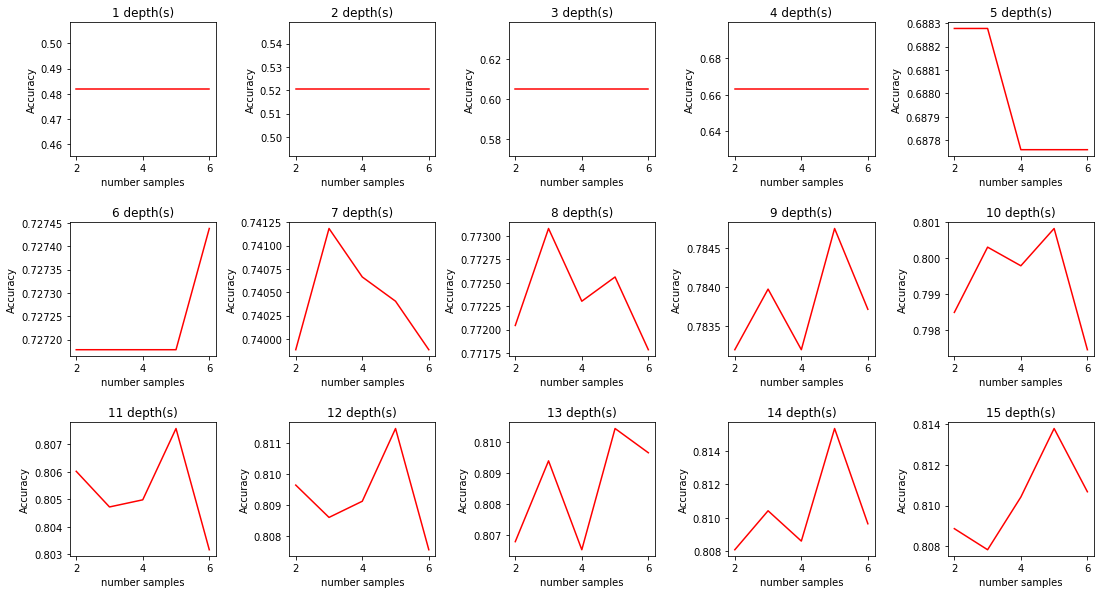

In [125]:
from sklearn import tree

#afin d'eviter le phenomene de overfitting, nous avons utiliser une des techniques de pré-elegage(stopper en amount lors de la creation de l'arbre)
#en limitant la profondeur de l'arbre et le nombre minimale de points pour une feuille
#To reduce memory consumption, the complexity and size of the trees
#To obtain a deterministic behaviour during fitting, random_state has to be fixed.
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature

# creating 3*5 figure with (15,8) dimensions 
fig, axes = plt.subplots(3, 5, figsize=(15, 8))

#Adjust the space and the position of the figures
fig.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.5)

#Variables initialisation
best_accuracy = 0

# max depth of the tree
max_depth = 1 

#minimum number of samples by leaf
min_samples_leaf =2 

#in order to make evaluation later (log loss, classification report)
best_class_Points = []
best_pred_probabilities = []

for depth, ax in zip(range(1,16), axes.ravel()):
    accuracy = []
    train_accuracy = []
    for n_samples in range(2,7):
        # we use the entropy impurity measure in order to maximize the information gain at each split
        dtc = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_leaf=n_samples, random_state=0)
        
        #train the decision tree
        dtc.fit(X_train,y_train)
        
        #test the decision tree
        classified_Points = dtc.predict(X_test)
        
        pred_probabilities = dtc.predict_proba(X_test)
        
        acc = dtc.score(X_test,y_test)
        
        #array of test accuracy to plot each depth setting, in order to mesure the infuence of the diffrent settings(depth , min samples per leaf) 
        accuracy.append(acc)
        
        max_depth, min_samples_leaf, best_accuracy, best_class_Points, best_pred_probabilities = (depth, n_samples, acc, classified_Points, pred_probabilities) if acc > best_accuracy else (max_depth, min_samples_leaf, best_accuracy, best_class_Points, best_pred_probabilities)  
        
    ax.plot(range(2,7), accuracy, color="r")
        
    ax.set_title("{} depth(s)".format(depth))
   
    ax.set_xlabel("number samples")
        
    ax.set_ylabel("Accuracy")
        

print("the best setting are:".format(dtc.score(X_train,y_train)))

print("max depth: ",max_depth," min_samples_leaf: ",min_samples_leaf,"the best accuracy: {:.3f}".format(best_accuracy))

# Cross Validation

In [126]:
# number of folds of the cross validatio, we have choose 5 kfolds(reserve 1 fold which represent 20% as test data set) in order to be able to compare with test_train_split validation with 20 % of test
k_folds = 5

#initialisation the best_depth with 1
best_depth = 1

#initialisation the best_accuracy with 0
best_accuracy = 0

#initialisation the best_min_samples_leaf (Defines the minimum samples (or observations) required in a terminal node or leaf) used to control the over fitting
best_min_samples= 2

#split the data into 5 stratified partition, using the technic of shuffling in order to shuffle the data set
skf = StratifiedKFold(n_splits= k_folds, shuffle=True, random_state = 66)

for depth in range(1,16):
    for n_samples in range(2,7):
        # we use the entropy impurity measure in order to maximize the information gain at each split
        dtc = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_leaf=n_samples, random_state=0)
    
        #return 5 scores of the validation process 
        scores = cross_val_score(dtc, X, y, cv=skf)
    
        #we calculate the mean of the scores (accuracy) in order to get the best estimation of our modele performance 
        acc = scores.mean()
    
        #compare actual accuracy with the best accuracy and get the new best accuracy and depth
        best_depth, best_accuracy, best_min_samples = (depth, acc, n_samples) if acc > best_accuracy else (best_depth, best_accuracy, best_min_samples)



In [127]:
print("Average cross-validation score: {:.3f}".format(best_accuracy), " with max_depth=",best_depth, " best_min_samples: ",best_min_samples)

Average cross-validation score: 0.814  with max_depth= 13  best_min_samples:  5


# Evaluation

In [128]:
#calculating the classification report evualation metric 
print(metrics.classification_report(y_test, best_class_Points))

#calculating the confusion matrix evualation metric 
print(metrics.confusion_matrix(y_test, best_class_Points))

#calculating the log loss evualation metric 
print("Log loss: {:.3f}".format(metrics.log_loss(y_test, best_pred_probabilities)))

              precision    recall  f1-score   support

           1       0.89      0.92      0.90      1219
           2       0.41      0.27      0.32        97
           3       0.58      0.56      0.57       435
           4       0.83      0.89      0.86       716
           5       0.57      0.44      0.50       104
           6       0.51      0.28      0.36        96
           7       0.86      0.88      0.87      1189

   micro avg       0.82      0.82      0.82      3856
   macro avg       0.66      0.61      0.63      3856
weighted avg       0.80      0.82      0.81      3856

[[1116   21   25   14    4    1   38]
 [  36   26    7   10    0    0   18]
 [  41    6  245   62   12    6   63]
 [   8    5   42  640    8    3   10]
 [   3    0   24   21   46    1    9]
 [   5    0   18   14    4   27   28]
 [  45    6   60   12    7   15 1044]]
Log loss: 3.412


In [30]:
from sklearn.tree import export_graphviz
export_graphviz(dtc, out_file="tree.dot", class_names=["1", "2", "3", "4", "5", "6", "7"],
                   feature_names=list(X), impurity=False, filled=True)

In [31]:
import graphviz 

with open ("tree.dot") as f:
        dot_graph = f.read()
display(graphviz.Source(dot_graph))

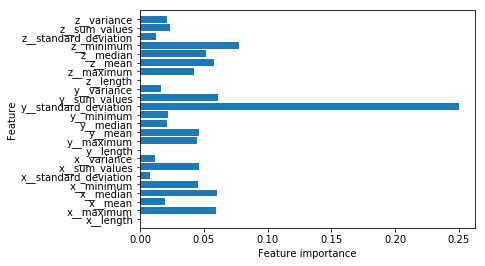

In [132]:
#Feature Importance array:measure the importance of each feature in decision making


dtc = tree.DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_leaf=5, random_state=0)
        
#train the decision tree
dtc.fit(X_train,y_train)

plot_feature_importances(dtc) 

# Forces et Faiblesses:

- Le modele peut facilement etre visualisé et compris par des non-expert.
- Ne necessite pas de prétraitement(normalisation ou bien standardisation) des données comme chaque caractéristique est traité séparément.
- Le principale inconvenient des arabres de decisions est que, meme avec un pré-élegage, Ils tendent vers le surapprentissage et fournissent de pietres performances de generalisation.
- C'est pourquoi nous allons utilisé une méthode dite ensembliste à la place d'arbre de décision unique comme le celebre Random Forest.

# Random Forest Classifier

Ensembles are methods that combine multiple machine learning models to create more powerful models. There are many models in the machine learning literature that belong to this category, but there are two ensemble models that have proven to be effective on a wide range of datasets for classification and regression, both of which use decision trees as their building blocks: **random forests** and **gradient boosted decision trees**.



- Random Forest Classifier is a collection of decision trees, in which each decision tree is totaly different to other decision trees.
- The objective is to reduce the overfitting of the decision trees, by training each decision tree independently to the other trees, this produce diffrent overfittings which help to reduce the totale overfitting.
- In order to do that we use random samples (bootstrap samples) and random features in each decision tree. 
- the number of features used in each node splitting process is controled by max_features.

the best accuracy on test set:0.869  with max_features =  9


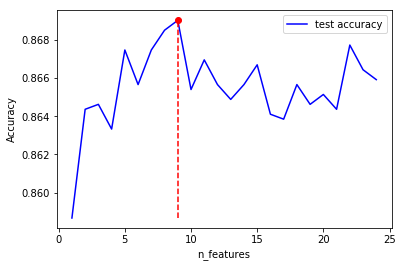

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#n_estimators: nombre d'arbres des randoms forests,

#array used to store the test accuracy
test_accuracy = []

n_features = 24

best_n_feature = 1
best_accuracy = 0

#max_features: le nombre max des caractérestique retenue aleatoirement pour faire la division au niveau de chaque noued 
feature_setting = range(1,25)

#3 coeur sont utilisé pour accelerer l'apprentissage des randomsforest
n_jobs=3

#in order to make evaluation later (log loss, classification report)
best_classified_Points = []
best_pred_probabilities = []

for k in feature_setting:
    # random forest with 100 decision tree 
    forest = RandomForestClassifier(n_estimators=100, n_jobs=n_jobs, max_features=k, random_state=66)
    
    #train the random forest
    forest.fit(X_train, y_train)
    
    #calculate the accuracy of the random forest
    accuracy = forest.score(X_test,y_test)
    
    #test the decision tree
    classified_Points = forest.predict(X_test)
        
    pred_probabilities = forest.predict_proba(X_test)
    
    #store the accuracy
    test_accuracy.append(accuracy)
    
    #get the best features
    best_n_feature, best_accuracy, best_classified_Points, best_pred_probabilities = (k, accuracy, classified_Points, pred_probabilities) if accuracy > best_accuracy else (best_n_feature, best_accuracy, best_classified_Points, best_pred_probabilities)

print("the best accuracy on test set:{:.3f}".format(best_accuracy)," with max_features = ",best_n_feature)

#plot the test accuracy 
plt.plot(feature_setting, test_accuracy, color="b", label="test accuracy")
plt.plot([best_n_feature,best_n_feature], [min(test_accuracy),best_accuracy], "r--")
plt.plot(best_n_feature, best_accuracy, "ro")

plt.ylabel("Accuracy")
plt.xlabel("n_features")
plt.legend()

# Cross Validation

In [136]:
# number of folds of the cross validation
k_folds = 5

#initialisation the best_k_neighbors with 1
best_depth = 1

#initialisation the best_accuracy with 0
best_accuracy = 0

#initialisation the best_n_samples with 0
best_n_feature= 1

#split the data into 5 stratified partition, using the technic of shuffling in order to shuffle the data set
skf = StratifiedKFold(n_splits= k_folds, shuffle=True, random_state = 66)

for k in range(1,24):
        # random forest with 100 decision tree 
        forest = RandomForestClassifier(n_estimators=100, n_jobs=3, max_features=k, random_state=66)    
        
        #return 5 scores of the validation process 
        scores = cross_val_score(forest, X, y, cv=skf)
    
        #we calculate the mean of the scores (accuracy) in order to get the best estimation of our modele performance 
        acc = scores.mean()
    
        #compare actual accuracy with the best accuracy and get the new best accuracy and depth
        best_n_feature, best_accuracy = (k, acc) if acc > best_accuracy else (best_n_feature, best_accuracy)

print("Average cross-validation score: {:.3f}".format(best_accuracy), " with best_n_feature=",best_n_feature)

Average cross-validation score: 0.865  with best_n_feature= 4


- On remarque que la meilleur résultat a été marqué pour max_features = 4, chose qui confirme l'hypothese que l'optimum du $max features=\sqrt[2]{number features}$ 

# Evaluation

In [133]:
#calculating the classification report evualation metric 
print(metrics.classification_report(y_test, best_classified_Points))

#calculating the confusion matrix evualation metric 
print(metrics.confusion_matrix(y_test, best_classified_Points))

#calculating the log loss evualation metric 
print("Log loss: {:.3f}".format(metrics.log_loss(y_test, best_pred_probabilities)))

              precision    recall  f1-score   support

           1       0.95      0.95      0.95      1219
           2       0.73      0.37      0.49        97
           3       0.74      0.61      0.67       435
           4       0.85      0.94      0.89       716
           5       0.73      0.47      0.57       104
           6       0.79      0.35      0.49        96
           7       0.86      0.95      0.90      1189

   micro avg       0.87      0.87      0.87      3856
   macro avg       0.81      0.66      0.71      3856
weighted avg       0.86      0.87      0.86      3856

[[1159    8    7   12    1    0   32]
 [  26   36    8    7    0    0   20]
 [  11    3  267   56   10    3   85]
 [   7    1   25  675    2    0    6]
 [   1    0   19   21   49    1   13]
 [   2    0   15   15    4   34   26]
 [  19    1   22   10    1    5 1131]]
Log loss: 0.512


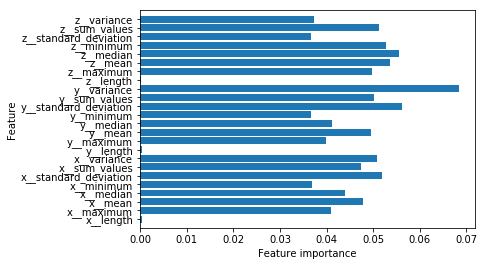

In [137]:
forest = RandomForestClassifier(n_estimators=100, max_features=4, random_state=66)
forest.fit(X_train, y_train)
plot_feature_importances(forest)

# Gradient Boosting classifier

In **contrast** to the **random forest approach**, **gradient boosting** works by building trees in a serial manner, where each tree tries to correct the mistakes of the previous one. By default, there is no randomization in gradient boosted regression trees; instead, strong **pre-pruning** (stop growing the tree earlier, before it perfectly classifies the training set) is used. **Gradient boosted** trees often use very shallow trees, of depth one to five, which makes the model smaller in terms of memory and makes predictions faster. The main idea behind gradient boosting is to combine many simple models (in this context known as weak learners), like shallow trees. Each tree can only provide good predictions on part of the data, and so more and more trees are added to **iteratively** improve performance.

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

best_max_depth = 1

best_accuracy = 0

#in order to make evaluation later (log loss, classification report)
best_classified_Points = []
best_pred_probabilities = []

best_lr = 0.12
accuracy = []
for l_r in [0.1 0.11 0.12 0.13]:
    # we use the best configuration of the decision anda random forest, because GBRT is based on collection of decision trees, and share the caracteristics of random forests and decision trees
    gbrt = GradientBoostingClassifier(random_state = 66, max_depth=15, max_features=4, min_samples_leaf=5, learning_rate=l_r)
    
    #train the gradient boost classifier
    gbrt.fit(X_train, y_train)
    
    #test the decision tree
    acc = gbrt.score(X_test,y_test)
    accuracy.append(acc)
    
    classified_Points = gbrt.predict(X_test)      
    pred_probabilities = gbrt.predict_proba(X_test)
    
    best_classified_Points, best_pred_probabilities, best_accuracy, best_lr = (classified_Points , pred_probabilities, acc, l_r) if acc > best_accuracy else (best_classified_Points, best_pred_probabilities, best_accuracy, best_lr)
    
print("the best accuracy on test set: {:.3f}".format(best_accuracy)," with learning rate= ", best_lr)

the best accuracy on test set: 0.875  with learning rate=  0.12


# Evaluation

In [20]:
from sklearn import metrics

#calculating the classification report evualation metric 
print(metrics.classification_report(y_test, best_classified_Points))

#calculating the confusion matrix evualation metric 
print(metrics.confusion_matrix(y_test, best_classified_Points))

#calculating the log loss evualation metric 
print("Log loss: {:.3f}".format(metrics.log_loss(y_test, best_pred_probabilities)))

              precision    recall  f1-score   support

           1       0.94      0.96      0.95      1219
           2       0.80      0.42      0.55        97
           3       0.76      0.63      0.69       435
           4       0.86      0.95      0.90       716
           5       0.72      0.48      0.58       104
           6       0.80      0.38      0.51        96
           7       0.87      0.95      0.91      1189

   micro avg       0.87      0.87      0.87      3856
   macro avg       0.82      0.68      0.73      3856
weighted avg       0.87      0.87      0.87      3856

[[1167    7    7    8    0    0   30]
 [  27   41    7    6    0    1   15]
 [  14    1  273   54   12    1   80]
 [   7    0   22  677    3    0    7]
 [   1    1   18   20   50    1   13]
 [   5    0   13   15    4   36   23]
 [  22    1   20   11    0    6 1129]]
Log loss: 0.590


# Comparison between the classifiers

Text(0.5, 0, 'Classifiers')

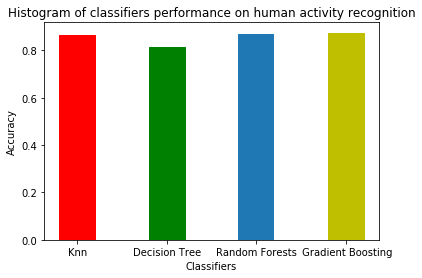

In [22]:

# Make fake dataset
classifiers_accuracy = [0.864, 0.815, 0.869, 0.875]

classifiers = ("Knn", "Decision Tree", "Random Forests", " Gradient Boosting")
 
# Choose the position of each barplots on the x-axis (space=1,4,3,1)
y_pos = [0,2,4,6]

 
# Create bars
barlist = plt.bar(y_pos, classifiers_accuracy)

#Setting the color of the bars
barlist[0].set_color('r')
barlist[1].set_color('g')
barlist[3].set_color('y')

# Create names on the x-axis
plt.xticks(y_pos, classifiers)


plt.title('Histogram of classifiers performance on human activity recognition') # add a title to the histogram
plt.ylabel('Accuracy') # add y-label
plt.xlabel('Classifiers') # add x-label

Text(0.5, 0, 'Classifiers')

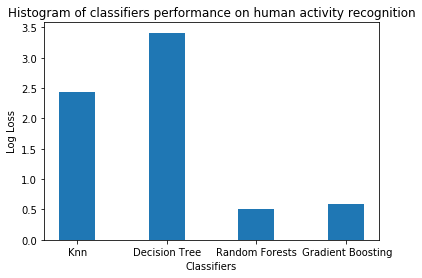

In [26]:
# Make fake dataset
log_loss = [2.434, 3.412, 0.512, 0.590]
classifiers = ("Knn", "Decision Tree", "Random Forests", " Gradient Boosting")
 
# Choose the position of each barplots on the x-axis (space=1,4,3,1)
y_pos2 = [1,3,5,7]
 
# Create bars
plt.bar(y_pos2, log_loss)
#Setting the color of the bars
barlist[0].set_color('r')
barlist[1].set_color('g')
barlist[3].set_color('y')

# Create names on the x-axis
plt.xticks(y_pos2, classifiers)

plt.title('Histogram of classifiers performance on human activity recognition') # add a title to the histogram
plt.ylabel('Log Loss') # add y-label
plt.xlabel('Classifiers') # add x-label